In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn.utils import prune
import matplotlib.pyplot as plt


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Define a CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [16]:
# Define a function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
# Define a function to train the model
def train(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return loss_history

In [7]:
# Define a function to evaluate the model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy


In [9]:
# Initialize model, criterion, and optimizer
original_model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(original_model.parameters())

print("Training Original Model...")
original_loss_history = train(original_model, train_loader, criterion, optimizer)
original_accuracy = evaluate(original_model, test_loader)

Training Original Model...
Epoch 1/5, Loss: 1.2527
Epoch 2/5, Loss: 0.8255
Epoch 3/5, Loss: 0.5753
Epoch 4/5, Loss: 0.3404
Epoch 5/5, Loss: 0.1581
Accuracy: 70.84%


In [10]:
# Structured pruning
def apply_structured_pruning(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name="weight", amount=0.5, n=2, dim=0)

structured_model = CNNModel().to(device)
structured_model.load_state_dict(original_model.state_dict())
apply_structured_pruning(structured_model)

print("Training Structured Pruned Model...")
optimizer = optim.Adam(structured_model.parameters())
structured_loss_history = train(structured_model, train_loader, criterion, optimizer)
structured_accuracy = evaluate(structured_model, test_loader)

Training Structured Pruned Model...
Epoch 1/5, Loss: 0.3685
Epoch 2/5, Loss: 0.1111
Epoch 3/5, Loss: 0.0711
Epoch 4/5, Loss: 0.0693
Epoch 5/5, Loss: 0.0570
Accuracy: 67.94%


In [11]:
# Unstructured pruning
def apply_unstructured_pruning(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.random_unstructured(module, name="weight", amount=0.5)

unstructured_model = CNNModel().to(device)
unstructured_model.load_state_dict(original_model.state_dict())
apply_unstructured_pruning(unstructured_model)

print("Training Unstructured Pruned Model...")
optimizer = optim.Adam(unstructured_model.parameters())
unstructured_loss_history = train(unstructured_model, train_loader, criterion, optimizer)
unstructured_accuracy = evaluate(unstructured_model, test_loader)


Training Unstructured Pruned Model...
Epoch 1/5, Loss: 0.2650
Epoch 2/5, Loss: 0.0735
Epoch 3/5, Loss: 0.0580
Epoch 4/5, Loss: 0.0553
Epoch 5/5, Loss: 0.0452
Accuracy: 69.71%


In [12]:
# Summarize results
print("\nResults:")
print(f"Original Model Accuracy: {original_accuracy:.2f}%")
print(f"Structured Pruned Model Accuracy: {structured_accuracy:.2f}%")
print(f"Unstructured Pruned Model Accuracy: {unstructured_accuracy:.2f}%")


Results:
Original Model Accuracy: 70.84%
Structured Pruned Model Accuracy: 67.94%
Unstructured Pruned Model Accuracy: 69.71%


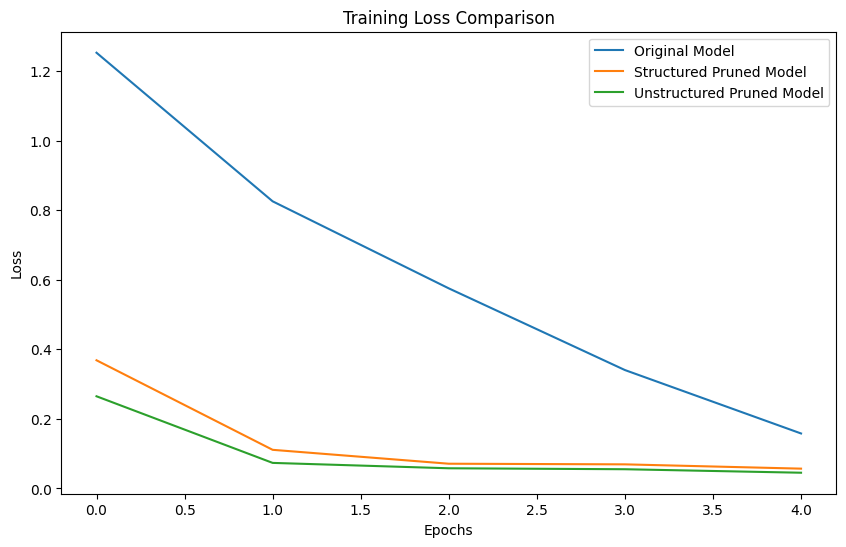

In [13]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(original_loss_history, label="Original Model")
plt.plot(structured_loss_history, label="Structured Pruned Model")
plt.plot(unstructured_loss_history, label="Unstructured Pruned Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()